<a href="https://colab.research.google.com/github/NKSTUD/Sentiment-classification-using-Deep-Neural-Network/blob/main/sentiment_classoifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
from sklearn.metrics import classification_report
from bs4 import BeautifulSoup
import re, string
from pprint import pprint
import nltk
from nltk.corpus import stopwords 
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout,LSTM,GlobalAveragePooling1D, Flatten,GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, auc,confusion_matrix
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import itertools

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/EXAMEN IA/Datasets/IMDB Dataset.csv")

# TRAITEMENT DE DONNEES

In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
pprint(df['review'][1])

('A wonderful little production. <br /><br />The filming technique is very '
 'unassuming- very old-time-BBC fashion and gives a comforting, and sometimes '
 'discomforting, sense of realism to the entire piece. <br /><br />The actors '
 'are extremely well chosen- Michael Sheen not only "has got all the polari" '
 'but he has all the voices down pat too! You can truly see the seamless '
 "editing guided by the references to Williams' diary entries, not only is it "
 'well worth the watching but it is a terrificly written and performed piece. '
 "A masterful production about one of the great master's of comedy and his "
 'life. <br /><br />The realism really comes home with the little things: the '
 "fantasy of the guard which, rather than use the traditional 'dream' "
 'techniques remains solid then disappears. It plays on our knowledge and our '
 'senses, particularly with the scenes concerning Orton and Halliwell and the '
 "sets (particularly of their flat with Halliwell's murals d

In [ ]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


#### sentiment count

In [ ]:
sentiment = df['sentiment'].value_counts()

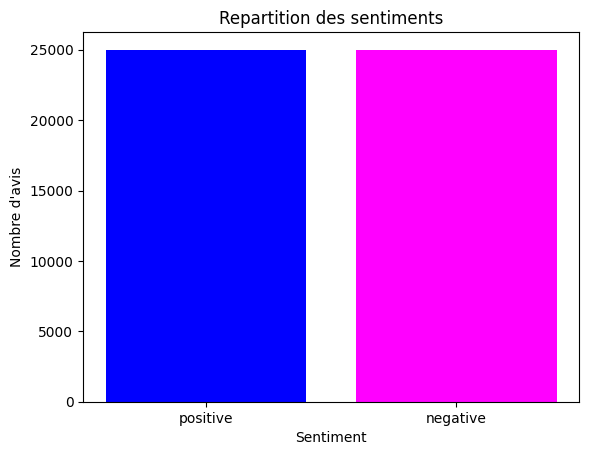

In [ ]:
fig, ax = plt.subplots()
colors = ["blue",'magenta']
# Tracer un graphique en barres avec les compteurs
ax.bar(sentiment.index, sentiment.values, color=colors)



# Ajouter des étiquettes et un titre
ax.set_xlabel('Sentiment')
ax.set_ylabel("Nombre d'avis")
ax.set_title('Repartition des sentiments')

# Afficher le graphique
plt.show()

In [ ]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [ ]:
df.isna().sum()

review       0
sentiment    0
dtype: int64

In [ ]:
len(df[df['review'].duplicated() == True])

418

In [ ]:
df = df.drop_duplicates(subset=['review'])

In [ ]:
df.shape

(49582, 2)

In [ ]:
def remove_html_tag(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

def remove_special_characters(text, remove_digits=True):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', text)
    text = re.sub('\[[^]]*\]','',text)
    return text

def clear_text(text):
    text = remove_html_tag(text)
    text = remove_special_characters(text, remove_digits=True)
    return text

df['review'] = df['review'].apply(clear_text)

<ipython-input-17-c974c07627a6>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


In [ ]:
df['review'][1]

'A wonderful little production The filming technique is very unassuming very oldtimeBBC fashion and gives a comforting and sometimes discomforting sense of realism to the entire piece The actors are extremely well chosen Michael Sheen not only has got all the polari but he has all the voices down pat too You can truly see the seamless editing guided by the references to Williams diary entries not only is it well worth the watching but it is a terrificly written and performed piece A masterful production about one of the great masters of comedy and his life The realism really comes home with the little things the fantasy of the guard which rather than use the traditional dream techniques remains solid then disappears It plays on our knowledge and our senses particularly with the scenes concerning Orton and Halliwell and the sets particularly of their flat with Halliwells murals decorating every surface are terribly well done'

In [ ]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
print(stop_words)


{'don', 'haven', 'did', 'me', 'up', 'd', 'only', 'if', 'be', 'her', 'hasn', 'he', 'through', 'once', 'that', 'some', 'theirs', 'whom', 'because', 'won', 'most', 'will', 'o', 'y', 'couldn', 'needn', "weren't", "you've", 'have', 'our', 'as', "mustn't", 'my', "isn't", 'same', 'how', 'yours', "you'd", 'being', 'it', 'from', 'yourself', 'they', 'or', 'of', 'on', 'few', "you'll", 'between', "you're", 'both', 'was', 'am', 'there', 'themselves', 'are', "shan't", 'them', 'is', 'too', "hasn't", 'all', 'against', "needn't", 'their', 'about', 'yourselves', 'so', 'nor', 'where', 'before', 'here', 'himself', 'until', 'the', 'by', 'aren', 'off', 'when', 's', 'these', "it's", 'such', 'weren', 'down', 'm', "hadn't", 'you', 'were', 'and', 'further', 'can', 'we', 'but', 'had', 'shouldn', 'each', 'been', 're', "aren't", 'him', 'doing', 'his', 'hadn', 'its', 'again', 'those', 'wasn', 'now', 'just', "should've", "she's", "that'll", 've', 'after', 'any', "mightn't", "don't", "shouldn't", 'very', 'why', 'havi

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import nltk
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
df.loc[:, 'review'] = df['review'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
stop_words = set(stopwords.words('english'))
df.loc[:, 'review'] = df['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))


In [ ]:
df.loc[:, 'review']=df['review'].apply(lambda x: x.lower())

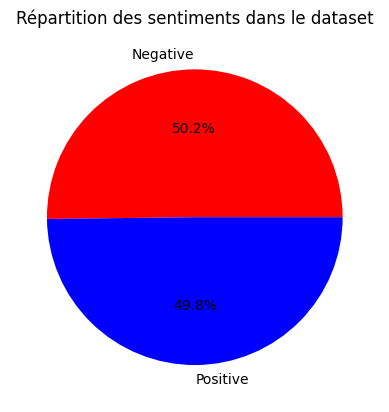

In [ ]:

sentiments = df['sentiment'].value_counts()
colors = ['red', 'blue']
fig, ax = plt.subplots()
ax.pie(sentiments, labels=["Negative", "Positive"], autopct='%1.1f%%', colors=colors)
ax.set_title("Répartition des sentiments dans le dataset")
plt.show()


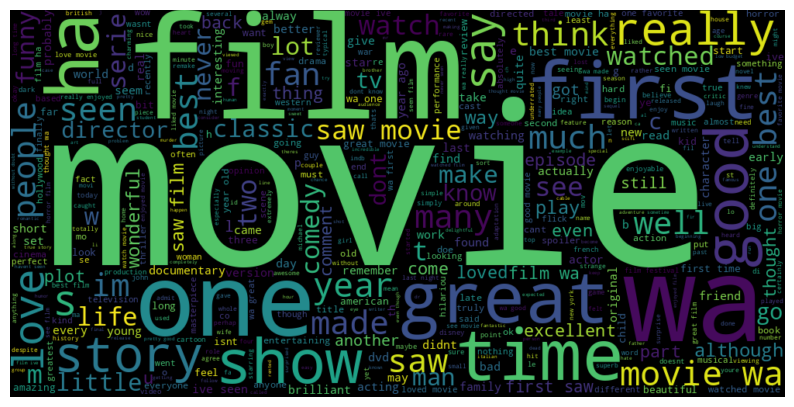

In [ ]:
plt.figure(figsize=(10, 10))

positive_text =df[df["sentiment"] == 'positive']['review'].to_string() 

WC = WordCloud(width=1000, height=500, max_words=500, min_font_size=5)
positive_words = WC.generate(positive_text)

plt.imshow(positive_words, interpolation='bilinear')
plt.axis('off')  # Remove axis labels
plt.show()


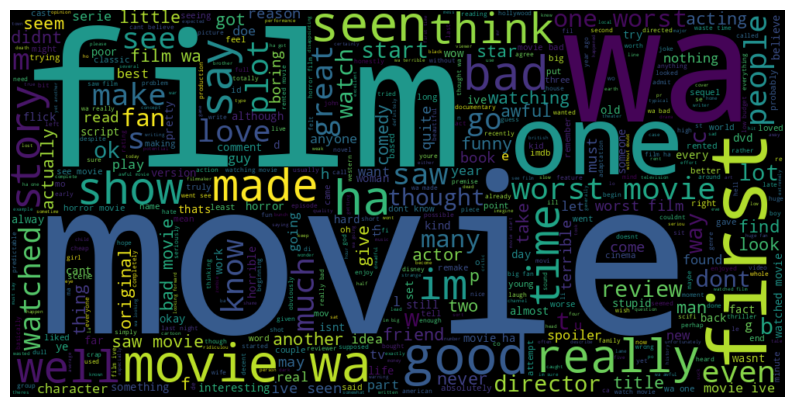

In [ ]:
plt.figure(figsize=(10, 10))

negative_text =df[df["sentiment"] == 'negative']['review'].to_string() 

WC = WordCloud(width=1000, height=500, max_words=500, min_font_size=5)
negative_words = WC.generate(negative_text)

plt.imshow(negative_words, interpolation='bilinear')
plt.axis('off')  # Remove axis labels
plt.show()


In [4]:
df = pd.read_pickle('/content/drive/MyDrive/EXAMEN IA/Datasets/IA_exam_data.pkl')

In [ ]:
df.head()

,review,sentiment
0,one reviewer ha mentioned watching 1 oz episod...,positive
1,wonderful little production filming technique ...,positive
2,thought wa wonderful way spend time hot summer...,positive
3,basically family little boy jake think zombie ...,negative
4,petter matteis love time money visually stunni...,positive


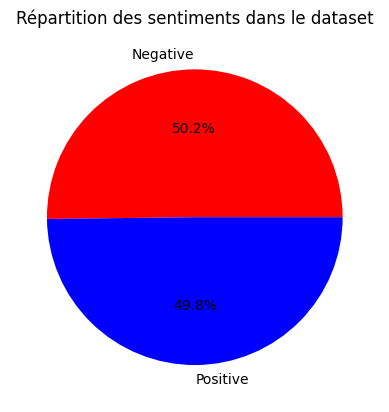

In [ ]:

sentiments = df['sentiment'].value_counts()
colors = ['red', 'blue']
fig, ax = plt.subplots()
ax.pie(sentiments, labels=["Negative", "Positive"], autopct='%1.1f%%', colors=colors)
ax.set_title("Répartition des sentiments dans le dataset")

plt.show()


In [ ]:
df['sentiment_encoded'] = df['sentiment'].map({'positive': 1, 'negative': 0})

In [ ]:
df.head()

,review,sentiment,sentiment_encoded
0,one reviewer ha mentioned watching 1 oz episod...,positive,1
1,wonderful little production filming technique ...,positive,1
2,thought wa wonderful way spend time hot summer...,positive,1
3,basically family little boy jake think zombie ...,negative,0
4,petter matteis love time money visually stunni...,positive,1


In [6]:
df.describe()

,review,sentiment
count,49582,49582
unique,49578,2
top,film easily rival emotional strength dramatic ...,positive
freq,2,24884


### Tokenisation

In [ ]:
reviews = df["review"].values
sentiments = df["sentiment"].values

# transform sentiment in two classes (postif:0, negatif :1)
le = LabelEncoder()
y = le.fit_transform(sentiments)
print(le.inverse_transform([0, 1]))
print(y)
print(df['sentiment_encoded'].to_numpy())


['negative' 'positive']
[1 1 1 ... 0 0 0]


In [ ]:
# Créer un tokenizer pour prétraiter les données de texte
tokenizer = Tokenizer(num_words=5000, lower=True)
tokenizer.fit_on_texts(reviews)
X = tokenizer.texts_to_sequences(reviews)
X = pad_sequences(X, maxlen=100)
word_index = tokenizer.word_index

In [ ]:
print(word_index['movie'])

1


In [ ]:
print(X)

[[2340  590  749 ...  778 3667  350]
 [   0    0    0 ... 1758   19  134]
 [   0    0    0 ...   33   15  115]
 ...
 [   0    0    0 ...  265  388 3575]
 [   0    0    0 ... 1859 2344  607]
 [   0    0    0 ...  898  734    1]]


### Data Spliting

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (39665, 100)
X_test shape: (9917, 100)


[0 1] [19759 19906]


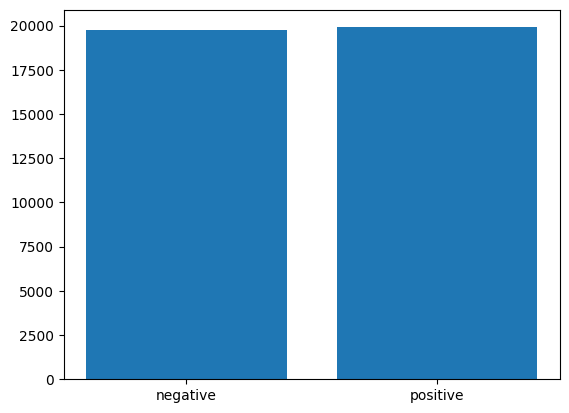

In [ ]:
unique_values, counts = np.unique(y_train, return_counts=True)
print(unique_values,counts)
plt.bar(["negative","positive"],counts)
plt.show()

In [ ]:
print(X_train[1])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0  722   35    1    6 2813    1
   50   93  717  403  156    1   73  562  563  152   68  136  275 1203
  603    1    2   80  286 1522   85    7    2    2  797  482 3433    1
   13  123  912   17   93   76  137   19    5  140   17  549  932   15
 3453 4454   64   15  896 2878  430    1   16 1096   80   83  398 2936
 4009 1276]


# PERFORMANCE FUNCTIONS


## confusion matrix

In [ ]:
def plot_confusion_matrix(model,cmap=plt.cm.Blues):
    y_pred = model.predict(X_test)
    y_pred = np.round(y_pred)
    cm = confusion_matrix(y_test, y_pred)
    classes = ["0", "1"]
    
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = "d"
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

## ROC graphe

In [ ]:
def ROC(model):
    # Faire des prédictions sur l'ensemble de validation
  y_pred= model.predict(X_test)

  # Calculer le taux de faux positifs et le taux de vrais positifs
  fpr, tpr, thresholds = roc_curve(y_test, y_pred)

  # Calculer l'aire sous la courbe ROC (RAUC)
  roc_auc = auc(fpr, tpr)

  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label='Courbe ROC (RAUC = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('Taux de faux positifs')
  plt.ylabel('Taux de vrais positifs')
  plt.title('Courbe ROC')
  plt.legend(loc="lower right")
  plt.show()

## model history

In [ ]:
def model_history(history):
      loss_curve = history.history["loss"]
      acc_curve = history.history["accuracy"]

      loss_val_curve = history.history["val_loss"]
      acc_val_curve = history.history["val_accuracy"]

      plt.plot(loss_curve, label='Train')
      plt.plot(loss_val_curve, label='Val')
      plt.legend()
      plt.title("Loss")
      plt.show()

      plt.plot(acc_curve, label = 'Train')
      plt.plot(acc_val_curve, label = 'Val')
      plt.legend()
      plt.title("Accuracy")
      plt.show()

## function to test de model 

In [ ]:
def classifier_sentiment(sentiments:list,model):
    seq = tokenizer.texts_to_sequences(sentiments)
    padded = pad_sequences(seq, maxlen=100)
    pred = model.predict(padded)
    for i in range(len(sentiments)):
        if pred[i][0]>=0.5:
            print(f"POSITIF A {round(pred[i][0], 2)*100:.2f}%")
        else:
            print(f"NEGATIVE A {round(1-pred[i][0], 2)*100:.2f}%")



```
# This is formatted as code
```

# MODELS

## CNN

In [ ]:
def build_cnn_model(vocab_size, embedding_dim, max_len):
    cnn_model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_len),
        Conv1D(filters=64, kernel_size=5, activation='relu'),
        MaxPooling1D(pool_size=4),
        Dropout(0.5),
        Conv1D(filters=128, kernel_size=5, activation='relu'),
        MaxPooling1D(pool_size=4),
        Dropout(0.5),
        Conv1D(filters=256, kernel_size=5, activation='relu'),
        GlobalMaxPooling1D(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    #summary = model.summary()
    return cnn_model


## LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dropout, Dense

def build_lstm_model(vocab_size, embedding_dim, max_len):
    lstm_model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_len),
        LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
        Dropout(0.5),
        LSTM(32),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return lstm_model


embedding_dim = 300
lstm_model_2 = Sequential()
lstm_model_2.add(Embedding(10000, embedding_dim))
# 2. Bag of Words
lstm_model_2.add(GlobalAveragePooling1D())
# 3. Classification
lstm_model_2.add(Dense(256, activation='relu'))
lstm_model_2.add(Dense(1, activation='sigmoid'))

# Compile
lstm_model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


## LSTM + CNN

In [ ]:
def build_lstm_cnn_model(vocab_size, embedding_dim, max_len):
    lstm_cnn_model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_len),
        Conv1D(filters=64, kernel_size=5, activation='relu'),
        MaxPooling1D(pool_size=4),
        LSTM(64, dropout=0.2, recurrent_dropout=0.2),
        Dense(1, activation='sigmoid')
    ])

    lstm_cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    #summary = model.summary()
    return lstm_cnn_model


## CNN + BiLSTM



In [ ]:
from tensorflow.keras.layers import Bidirectional
def build_cnn_bilstm_model(vocab_size, max_sequence_length, embedding_dim, num_classes, learning_rate):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=3))
    model.add(Bidirectional(LSTM(units=64)))
    model.add(Dense(units=num_classes, activation='sigmoid'))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model




## CNN + PARAMETERS TUNNING

## create model

In [ ]:
vocab_size =10000
embedding_dim = 100
max_len=100

print(vocab_size)

10000


In [ ]:
cnn_model = build_cnn_model(vocab_size, embedding_dim, max_len)

In [ ]:
lstm_model = build_lstm_model(vocab_size, embedding_dim, max_len)


In [ ]:
lstm_cnn_model =build_lstm_cnn_model(vocab_size, embedding_dim, max_len)

In [ ]:
# Example usage
vocab_size = 10000
max_sequence_length = 100
embedding_dim = 300
num_classes = 1  # For binary classification
learning_rate = 0.001

cnn_bilstm_model = build_cnn_bilstm_model(vocab_size, max_sequence_length, embedding_dim, num_classes, learning_rate)


Epoch 1/2
1984/1984 [==============================] - 94s 40ms/step - loss: 0.3420 - accuracy: 0.8467 - val_loss: 0.2817 - val_accuracy: 0.8790
Epoch 2/2
1984/1984 [==============================] - 27s 14ms/step - loss: 0.2288 - accuracy: 0.9096 - val_loss: 0.2899 - val_accuracy: 0.8791


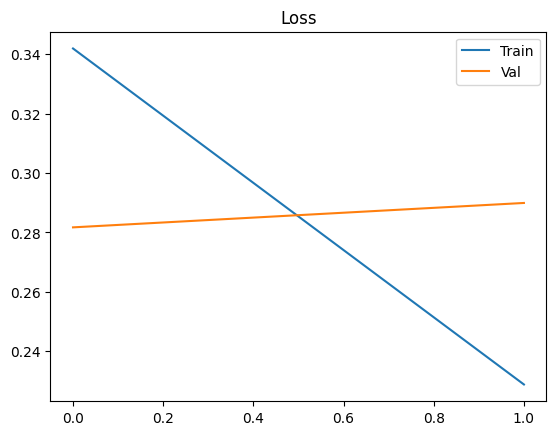

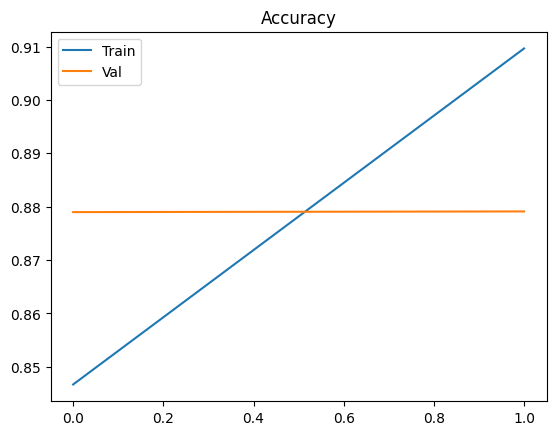

In [ ]:
history = cnn_bilstm_model.fit(X_train,y_train,validation_split=0.2,epochs=2,batch_size=64)
model_history(history)

Epoch 1/2
1984/1984 [==============================] - 342s 169ms/step - loss: 0.3367 - accuracy: 0.8506 - val_loss: 0.3131 - val_accuracy: 0.8630
Epoch 2/2
1984/1984 [==============================] - 269s 135ms/step - loss: 0.2230 - accuracy: 0.9123 - val_loss: 0.2905 - val_accuracy: 0.8810


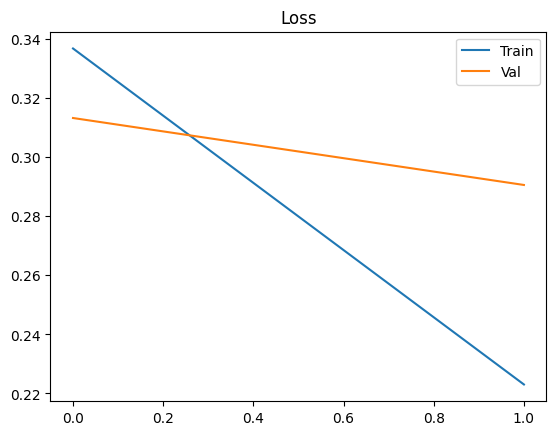

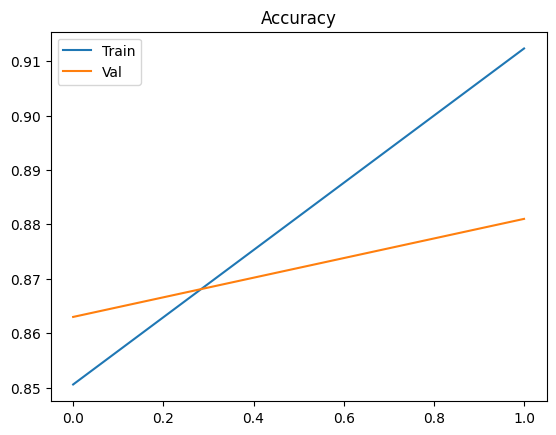

In [ ]:
#history = lstm_cnn_model.fit(X_train,y_train,validation_split=0.2,epochs=2,batch_size=16)
#model_history(history)


In [ ]:
#history = lstm_model_2.fit(X_train,y_train,validation_split=0.2,epochs=3,batch_size=64)
#model_history(history)

In [ ]:
#lstm_cnn_model.save("/content/drive/MyDrive/EXAMEN IA/Models/91.29_lstm_cnn_model.h5")

In [ ]:
#lstm_model_2.save("/content/drive/MyDrive/EXAMEN IA/Models/91_OV_lstm_model.h5")

In [ ]:
#ROC(lstm_cnn_model)

In [ ]:
positive_paragraphs = [    "Every day is a gift, and I am grateful for the opportunities and experiences that come my way. I try to live in the moment and enjoy every little thing, whether it's a sunny day or a cozy night in. Life can be unpredictable, but I choose to focus on the positive and find joy in the journey.",    "My loved ones are my biggest source of happiness and support. Their unwavering love and encouragement have helped me through tough times and inspired me to be my best self. I cherish every moment I spend with them, and I am grateful for their presence in my life.",    "Achieving my goals and dreams is an amazing feeling. It takes hard work, dedication, and perseverance, but the sense of accomplishment is worth it. Every small step forward is a victory, and I am proud of myself for never giving up on what I believe in.",    "Nature has a way of calming and rejuvenating my soul. Whether it's a walk in the park or a hike in the mountains, I find solace in the beauty and wonder of the natural world. It reminds me of how small I am in the grand scheme of things and puts my worries into perspective.",    "Helping others is one of the most fulfilling things I can do. Whether it's volunteering my time, donating to a cause, or simply lending an ear, I believe that small acts of kindness can make a big difference. Knowing that I have made someone's day a little brighter fills me with warmth and happiness.",    "Learning new things is a lifelong journey that I enjoy every step of the way. From picking up a new hobby to studying a new language, I believe that knowledge is power and that every new skill opens up new doors and opportunities. It keeps my mind sharp and my curiosity alive.",    "Surrounding myself with positive and supportive people is crucial for my well-being. They lift me up when I am down, celebrate my successes, and challenge me to be my best self. They are my tribe, and I am grateful for their presence in my life.",    "Believing in myself and my abilities is essential for achieving my goals. It's not always easy, and there are times when doubt creeps in, but I remind myself of how far I have come and the obstacles I have overcome. I am capable of great things, and I refuse to let fear hold me back.",    "The little things in life are what bring me the most joy. Whether it's a good cup of coffee, a warm hug, or a funny joke, it's the small moments that make life worth living. I try to appreciate them as much as possible and find happiness in the present.",    "Taking care of myself, both physically and mentally, is crucial for my overall well-being. From exercising regularly to practicing mindfulness, I believe that self-care is a priority, not a luxury. It allows me to show up as my best self for myself and for others."]
negative_paragraphs = [    "The day started out with a torrential downpour that soaked me to the bone. My mood was dampened further when I arrived at work to find a pile of urgent tasks on my desk.",    "I woke up this morning feeling absolutely miserable. My throat was sore, my head was pounding, and my nose was completely blocked.",    "My car broke down on the way to an important meeting, leaving me stranded on the side of the road for hours. By the time I finally arrived, I had missed the entire thing.",    "I received a rejection letter from the job I had been hoping to get. It felt like all of my hard work and effort had been for nothing.",    "I had a terrible fight with my partner last night, and now we're barely speaking to each other. I feel like everything is falling apart.",    "I got stuck in traffic on my way to pick up my kids from school, and ended up being late. They were so upset and disappointed, and I felt like a terrible parent.",    "I accidentally spilled coffee all over my laptop this morning, destroying all of my important files and documents. It was a complete disaster.",    "I received some devastating news about a close friend or family member, and I'm struggling to come to terms with it. Everything feels so overwhelming right now.",    "I had been looking forward to a vacation for months, but it ended up being a total disaster. The weather was terrible, the accommodations were awful, and nothing went according to plan.",    "I worked really hard on a project at school or work, only to receive a poor grade or negative feedback. It was a huge blow to my confidence and self-esteem."]
m_positive_paragraphs = [    "The sun was shining brightly, casting a warm glow over the park. People were out and about, enjoying the beautiful weather.",    "I just finished reading the most amazing book. The characters were so well-developed and the plot was captivating.",    "Last night's dinner was fantastic. The food was delicious and the service was impeccable.",    "I had a great workout this morning. I feel energized and ready to take on the day.",    "The concert last night was phenomenal. The music was so powerful and the energy in the room was electric.",    "I recently discovered a new hobby and it has brought so much joy into my life. I love spending my free time on it.",    "I just got back from a wonderful vacation. The scenery was breathtaking and the memories will last a lifetime.",    "I had a really productive day at work. I accomplished everything on my to-do list and even got ahead on some projects.",    "I watched a heartwarming movie last night that brought tears to my eyes. The message of love and hope was so powerful.",    "I received some great news today that made my day. It was exactly what I needed to hear and I am so grateful."]
m_negative_paragraphs = [    "I woke up feeling exhausted this morning. I didn't get enough sleep and now I am struggling to stay awake.",    "I had a terrible experience at the restaurant last night. The food was cold and the waiter was rude.",    "I am so frustrated with my job right now. The workload is overwhelming and I don't feel appreciated.",    "I got into an argument with a friend today and it left me feeling upset and angry.",    "I have been feeling really lonely lately. It seems like everyone around me is too busy to spend time with me.",    "I have a headache that just won't go away. I've tried everything to get rid of it but nothing seems to help.",    "I was really excited for a movie that came out last weekend but it turned out to be a huge disappointment.",    "I'm dealing with a lot of stress and anxiety right now. It's hard to focus on anything else.",    "I got stuck in traffic on my way to an important meeting this morning. I was late and it set the tone for the rest of the day.",    "I received some bad news today that has left me feeling defeated. I'm not sure how to move forward."]


In [ ]:
cnn_1 = tf.keras.models.load_model('/content/drive/MyDrive/EXAMEN IA/Models/model_91.53_acc.h5')
cnn_2 = tf.keras.models.load_model('/content/drive/MyDrive/EXAMEN IA/Models/93.27_little_overfit.h5')
cnn_3 = tf.keras.models.load_model('/content/drive/MyDrive/EXAMEN IA/Models/89_lstm_model.h5')

lstm_1 = tf.keras.models.load_model('/content/drive/MyDrive/EXAMEN IA/Models/89_lstm_model.h5')
lstm_2 = tf.keras.models.load_model('/content/drive/MyDrive/EXAMEN IA/Models/91_OV_lstm_model.h5')
lstm_3 = tf.keras.models.load_model('/content/drive/MyDrive/EXAMEN IA/Models/90_lstm_model.h5')

lstm_cnn_1 = tf.keras.models.load_model('/content/drive/MyDrive/EXAMEN IA/Models/91.29_lstm_cnn_model.h5')
lstm_cnn_2 = tf.keras.models.load_model('/content/drive/MyDrive/EXAMEN IA/Models/90.94_lstm_cnn_model.h5')
lstm_cnn_3 = tf.keras.models.load_model('/content/drive/MyDrive/EXAMEN IA/Models/91.14_lstm_cnn_model.h5')



In [ ]:
list_models = [
    cnn_1,cnn_2,cnn_3,lstm_1, lstm_2, lstm_3, lstm_cnn_1,lstm_cnn_2, lstm_cnn_3,
]

In [ ]:
for model in list_models:
  y_pred = model.predict(X_test)
  y_pred = np.round(y_pred)
  print(f"{model.__repr__}\n {classification_report(y_test,y_pred)}\n\n")

310/310 [==============================] - 1s 2ms/step
               precision    recall  f1-score   support

           0       0.86      0.85      0.85      4939
           1       0.85      0.86      0.86      4978

    accuracy                           0.85      9917
   macro avg       0.86      0.85      0.85      9917
weighted avg       0.86      0.85      0.85      9917



310/310 [==============================] - 1s 2ms/step
               precision    recall  f1-score   support

           0       0.87      0.85      0.86      4939
           1       0.85      0.87      0.86      4978

    accuracy                           0.86      9917
   macro avg       0.86      0.86      0.86      9917
weighted avg       0.86      0.86      0.86      9917



310/310 [==============================] - 1s 2ms/step
               precision    recall  f1-score   support

           0       0.88      0.85      0.87      4939
           1       0.86      0.89      0.87      4978

    accura

310/310 [==============================] - 1s 2ms/step


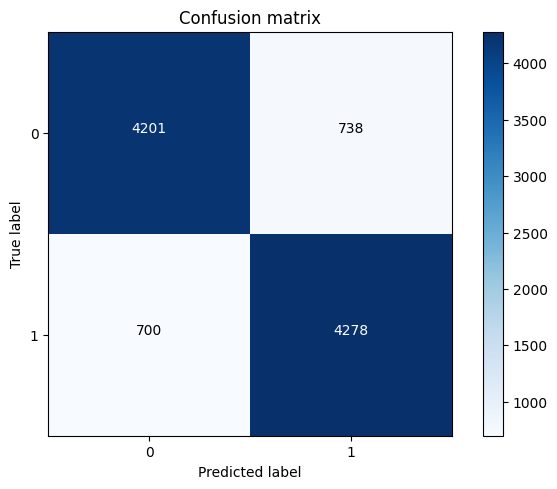

310/310 [==============================] - 1s 2ms/step


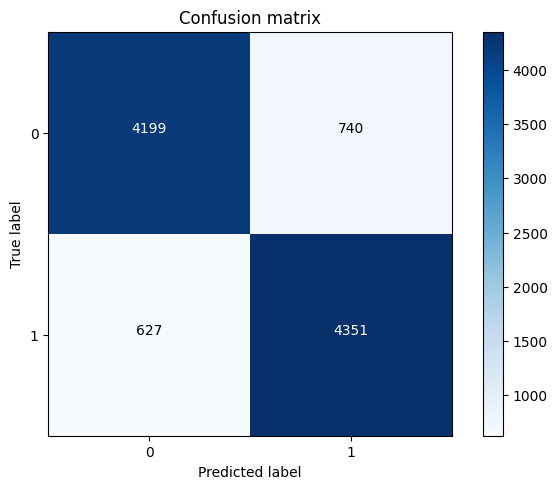

310/310 [==============================] - 0s 1ms/step


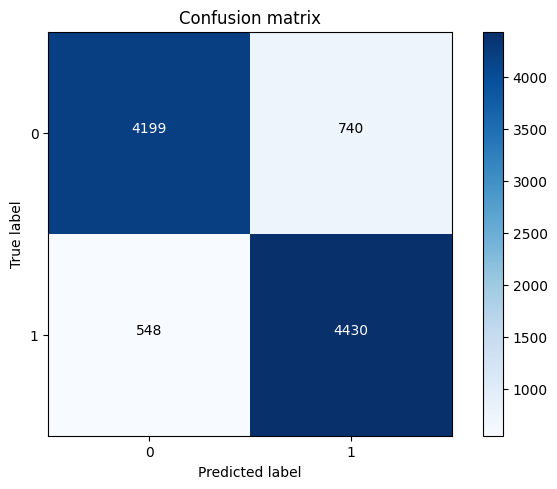

310/310 [==============================] - 1s 2ms/step


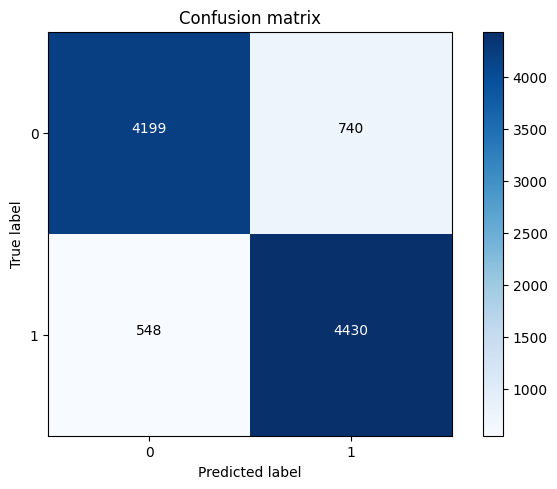

310/310 [==============================] - 1s 2ms/step


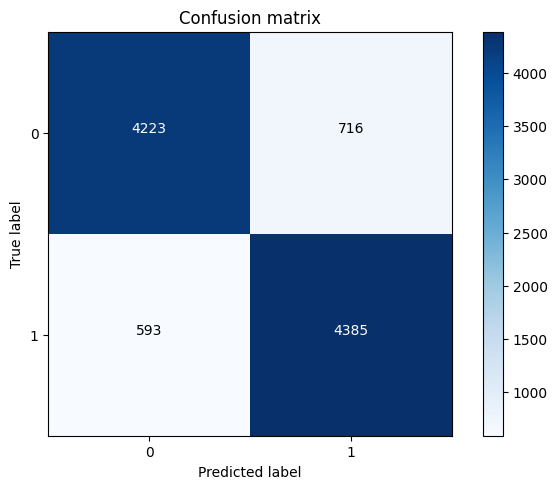

310/310 [==============================] - 1s 2ms/step


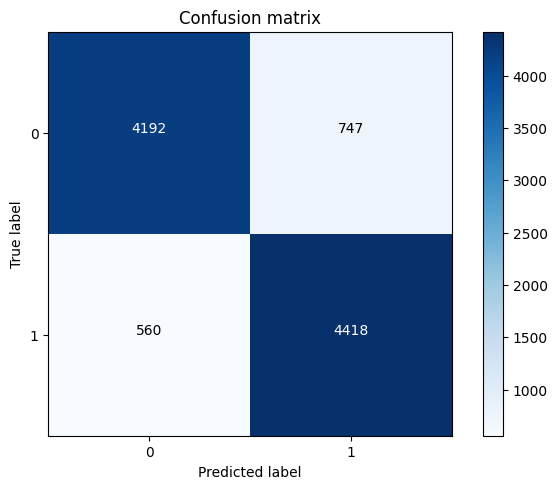

310/310 [==============================] - 4s 12ms/step


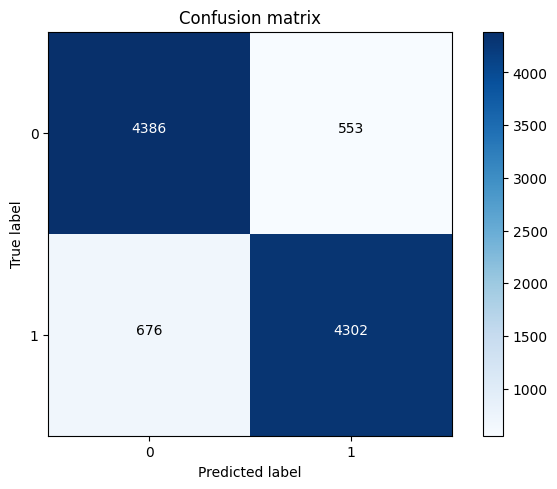

310/310 [==============================] - 3s 9ms/step


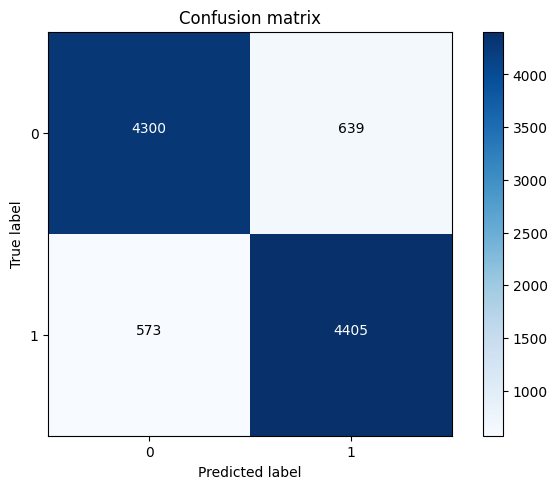

310/310 [==============================] - 3s 9ms/step


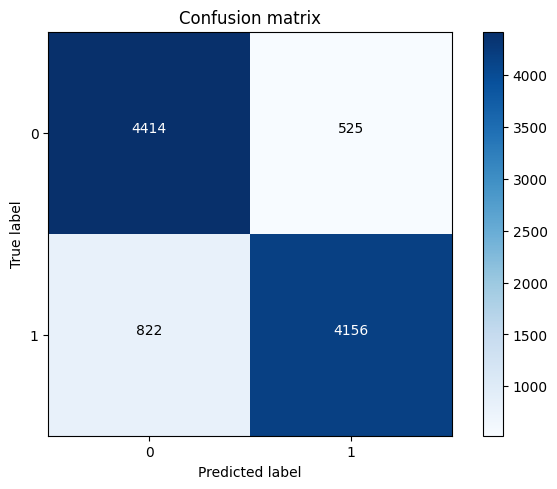

In [ ]:
for model in list_models:
  plot_confusion_matrix(model)

310/310 [==============================] - 1s 2ms/step


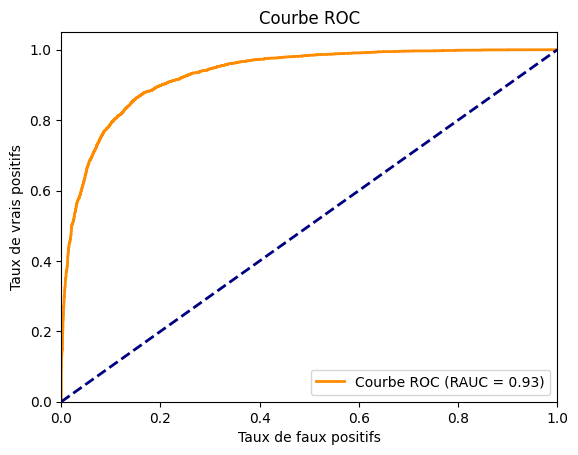

310/310 [==============================] - 1s 3ms/step


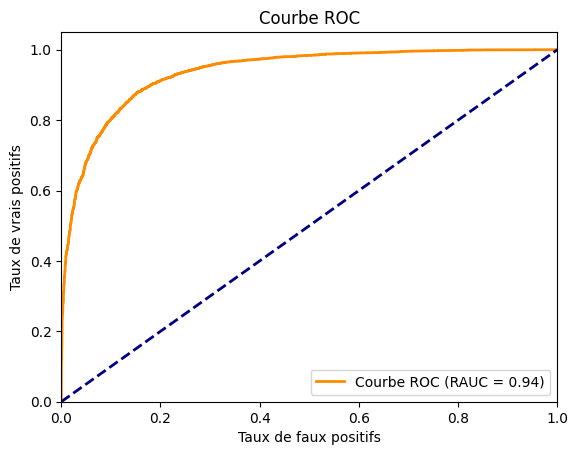

310/310 [==============================] - 1s 2ms/step


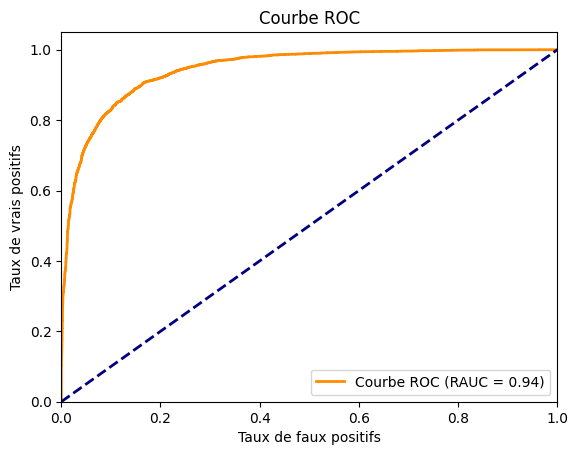

310/310 [==============================] - 0s 2ms/step


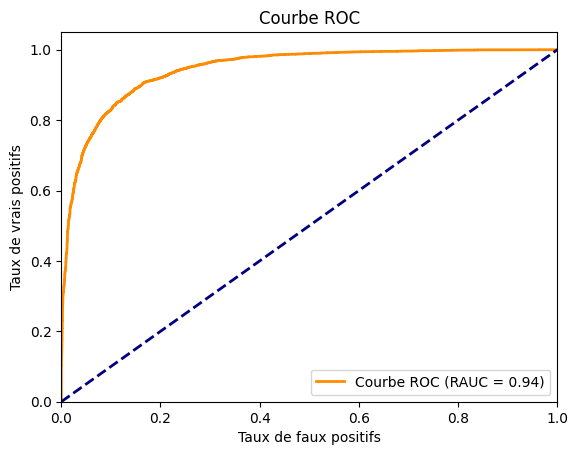

310/310 [==============================] - 1s 2ms/step


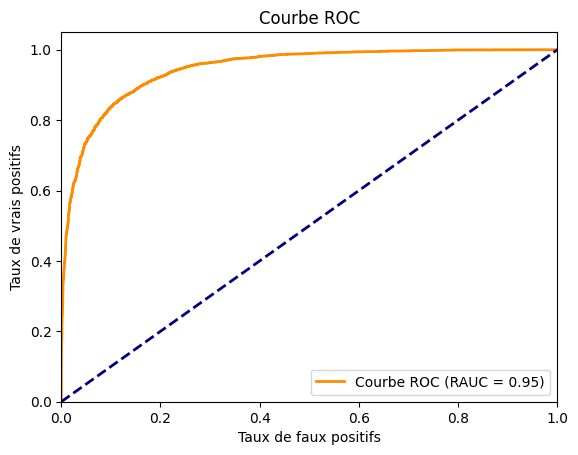

310/310 [==============================] - 1s 2ms/step


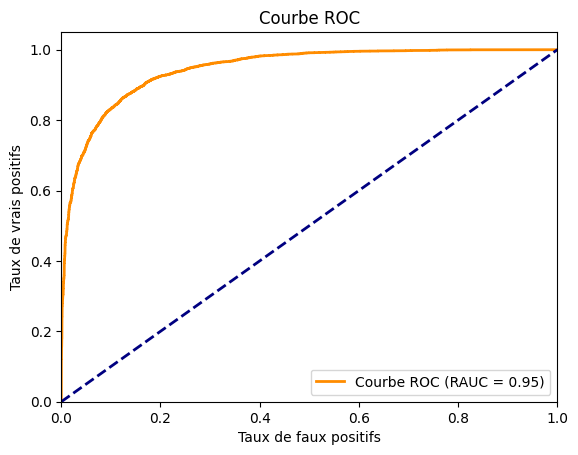

310/310 [==============================] - 3s 9ms/step


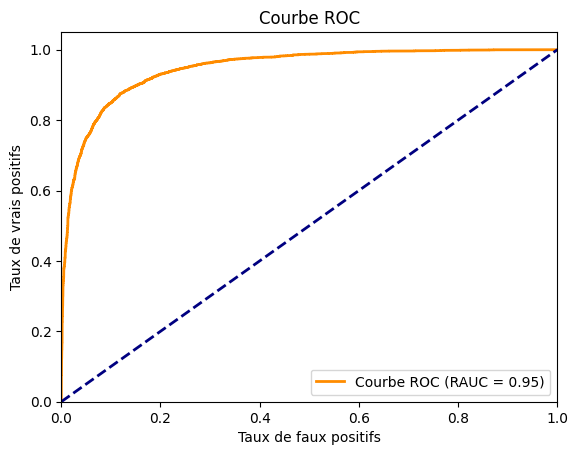

310/310 [==============================] - 3s 10ms/step


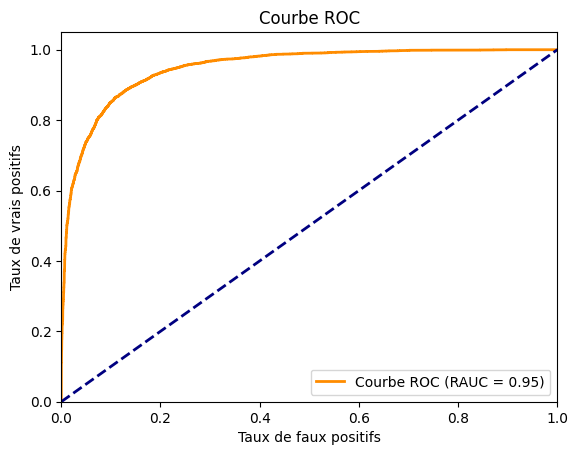

310/310 [==============================] - 3s 9ms/step


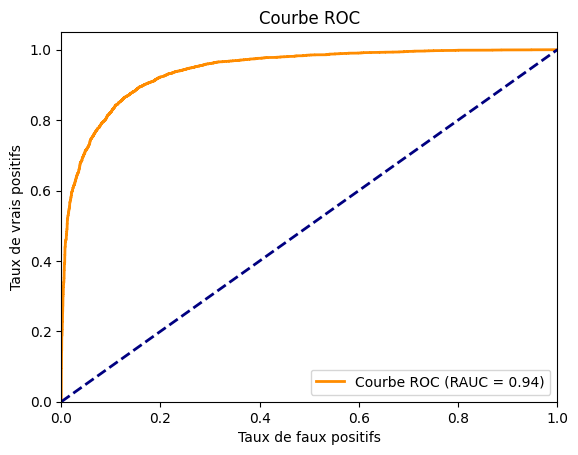

In [ ]:
for model in list_models:
  ROC(model)
  

310/310 [==============================] - 3s 9ms/step


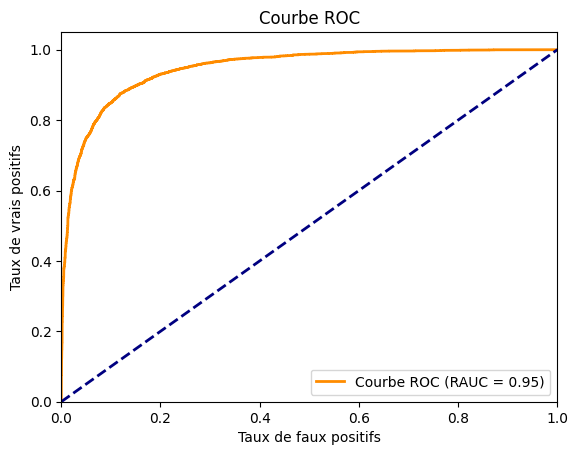

In [ ]:
ROC(lstm_cnn_1)

In [ ]:
classifier_sentiment(negative_paragraphs,model1)

In [ ]:
import sys
print(sys.version)
import tensorflow as tf
print(tf.__version__)


310/310 [==============================] - 8s 25ms/step


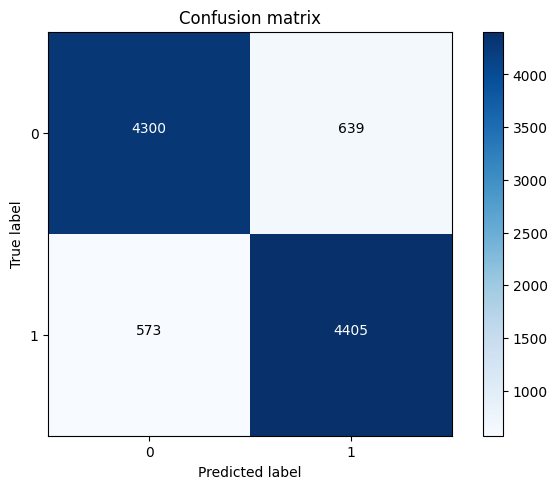

310/310 [==============================] - 5s 13ms/step


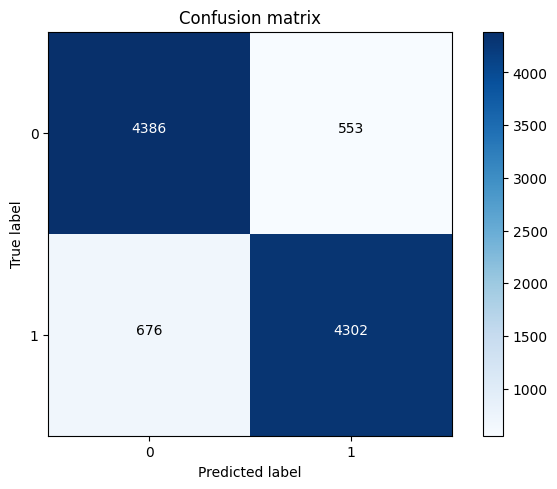

In [ ]:
plot_confusion_matrix(lstm_cnn_2)
plot_confusion_matrix(lstm_cnn_1)

In [ ]:
lstm_cnn_2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 conv1d_7 (Conv1D)           (None, 96, 64)            32064     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 24, 64)           0         
 1D)                                                             
                                                                 
 lstm_6 (LSTM)               (None, 64)                33024     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,065,153
Trainable params: 1,065,153
Non-trainable params: 0
____________________________________________

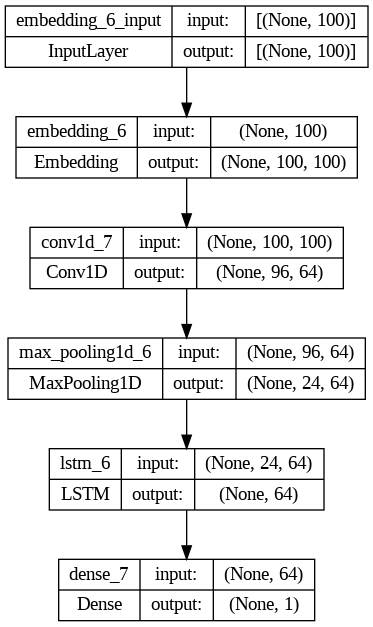

In [ ]:

tf.keras.utils.plot_model(lstm_cnn_2, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
classifier_sentiment(m_positive_paragraphs,lstm_cnn_2 )

1/1 [==============================] - 1s 650ms/step
POSITIF A 98.00%
POSITIF A 93.00%
POSITIF A 77.00%
POSITIF A 95.00%
POSITIF A 87.00%
POSITIF A 91.00%
POSITIF A 88.00%
POSITIF A 80.00%
POSITIF A 98.00%
POSITIF A 95.00%


In [ ]:
classifier_sentiment(negative_paragraphs,lstm_cnn_2 )

1/1 [==============================] - 0s 35ms/step
POSITIF A 72.00%
NEGATIVE A 57.00%
POSITIF A 72.00%
NEGATIVE A 90.00%
NEGATIVE A 84.00%
NEGATIVE A 95.00%
NEGATIVE A 84.00%
POSITIF A 83.00%
NEGATIVE A 100.00%
NEGATIVE A 82.00%


In [ ]:
classifier_sentiment(negative_paragraphs,lstm_1 )

1/1 [==============================] - 0s 22ms/step
NEGATIVE A 66.00%
NEGATIVE A 71.00%
POSITIF A 54.00%
NEGATIVE A 91.00%
NEGATIVE A 89.00%
NEGATIVE A 76.00%
NEGATIVE A 81.00%
NEGATIVE A 50.00%
NEGATIVE A 100.00%
NEGATIVE A 81.00%


310/310 [==============================] - 8s 25ms/step


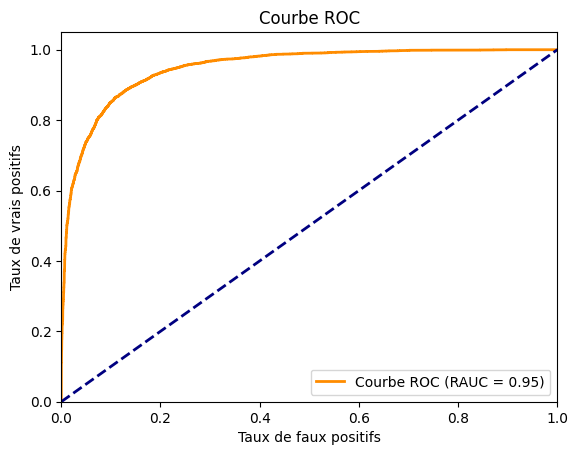

In [ ]:
ROC(lstm_cnn_2)